<a href="https://colab.research.google.com/github/cysorianoc/ShareWind/blob/main/SW_02_PROCESSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: Processing Data from ShareWind Test SW_02

## This notebook processes experimental data from the centrifuge test campaign SW_02, conducted as part of the ShareWind project (Shared Anchors for Floating Wind Turbines, Grant agreement 101106921).



![](https://upload.wikimedia.org/wikipedia/commons/1/1e/Offshore_wind_farm.gif?20210106062158)



The SW_02 test, performed on June 18, 2024, investigated the behavior of suction anchors installed in normally consolidated clay under different loading conditions.

The experiment involved three suction anchors embedded in a Speswhite kaolin clay specimen prepared to simulate a normally consolidated profile. The test sequence included one monotonic load test and two cyclic load tests. The objective was to analyze anchor response, particularly displacement accumulation and post-cyclic load capacity.

The data processed in this notebook includes measurements from load cells, pore pressure transducers (PPTs), and displacement sensors, recorded during these tests. Note that the raw data provided is at **model scale**. Appropriate scaling laws (using a model-prototype scale factor of N=75) must be applied to convert results to **prototype scale**. Refer to the original data report for details on the experimental setup, instrumentation, test chronology, and scaling laws.

This notebook aims to load, process, and visualize the key results from the SW_02 test campaign datasets
 - SW_02_1_I_MO
 - SW_02_2_I_CY
 - SW_02_3_I_CY
 - T-bar tests

# Run the following code lines to download the datafiles from the project repository

In [19]:
# Install wget lybrary to download files from the internet. We sil use it to retrieve files from the data repository
!pip3 install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=dd0a7a257aa3a3c0b5daaff03e3149e1da920b89cd0286c810acd2e3aac2ce08
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [20]:
# import the library after installing
import wget

# Anchor 1: Monotonic load test






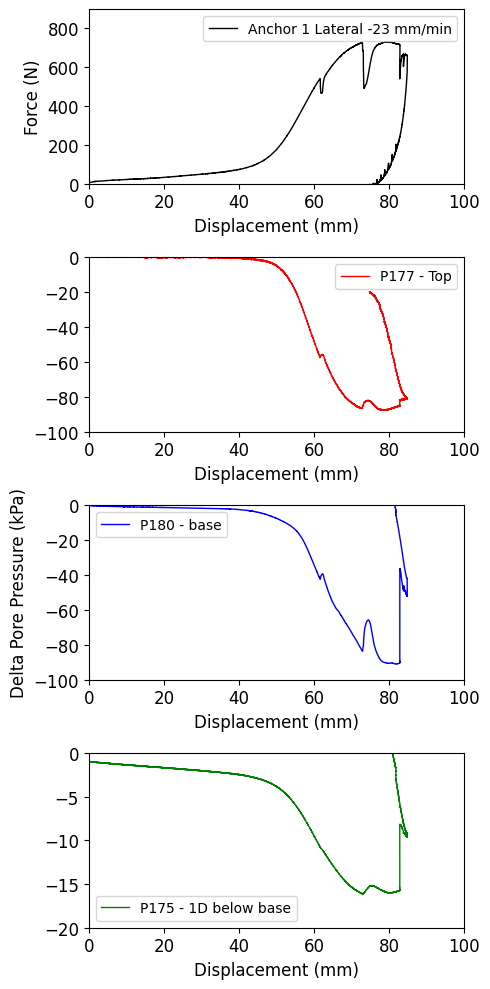

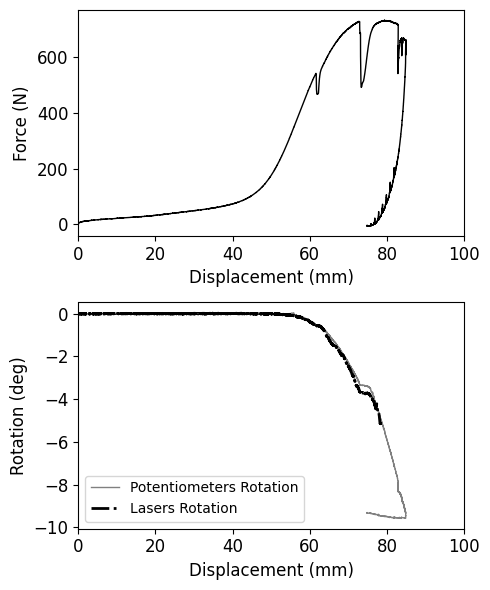

In [25]:
# Import necessary libraries
import pandas as pd  # For data manipulation and reading CSV files
import numpy as np  # For numerical operations, especially array manipulations
from scipy.signal import savgol_filter # For smoothing data (specifically force data)
import matplotlib.pyplot as plt # For creating plots and visualizations

# --- Data Loading and Constants ---

# Load data from the CSV file for Anchor 1 Monotonic Inclined test (SW_02_1_I_MO)
# Assumes the CSV file is in the same directory or path is specified
# .values converts the pandas DataFrame into a NumPy array for easier indexing

datafile = wget.download( "https://zenodo.org/records/15174989/files/SW_02_1_I_MO.csv?download=1")  # download the file SW_02_1_I_MO.csv
data = pd.read_csv('SW_02_1_I_MO.csv').values


# Define constants based on the experimental setup described in the data paper
N = 75   # Centrifuge acceleration level (g-level)
L = 200  # Anchor length in mm (model scale)
d = 60   # Anchor diameter in mm (model scale)
mass = 218.3 # Submerged anchor weight in grams (model scale)

# --- Calculations ---

# Calculate the equivalent prototype anchor weight in MegaNewtons (MN)
# Scaling law for mass: Prototype Mass = Model Mass * N^3
# Convert grams to kg (/1000), then kg to N (*g=9.81, approximated as 10 for calculation convenience or specific lab practice - check source paper context if precision needed)
# Convert N to MN (/1e6)
# Note: The factor 0.01 might represent gravity (approx 9.81 m/s^2) / 1000 (g to kg). Verify based on source paper's conventions.
wprot = mass * (N ** 3) * 0.01 / 1e6 # Calculation needs verification based on intended use of 0.01

# --- Data Processing (Model Scale) ---
# Extract and process data columns for model scale analysis

# Time array (Column 1, index 0)
time = data[:, 0]

# Force measured by actuator (Column 2, index 1)
# Apply offset correction: Subtract the mean of the initial readings (first 20 points) to zero the baseline
# Apply an additional manual offset (-0.83 N) - this might be based on specific test observations or calibration refinement.
mforce2 = data[:, 1] - np.mean(data[:20, 1]) - 0.83

# Displacement measured by actuator (Column 10, index 9)
# Apply offset correction: Subtract the mean of the initial readings (first 20 points)
# Invert the sign (* -1) to match displacement convention (e.g., positive pullout displacement)
mdispl2 = (data[:, 9] - np.mean(data[:20, 9])) * -1

# --- Data Processing (Prototype Scale) ---
# Scale the model data to prototype equivalents using centrifuge scaling laws

# Time (Scaling law: T_prototype = T_model * N)
time2 = time * N

# Force (Scaling law: F_prototype = F_model * N^2)
# Convert force units from N to MN (/1e6)
# Apply offset correction at prototype scale based on initial readings
force2 = (data[:, 1] * (N ** 2) / 1e6) - np.mean(data[:20, 1] * (N ** 2) / 1e6)
# Apply Savitzky-Golay filter to smooth the prototype force data
# window_length=15, polyorder=1: Uses a 15-point window and a 1st-order polynomial for smoothing
force2 = savgol_filter(force2, window_length=15, polyorder=1)

# Displacement (Scaling law: D_prototype = D_model * N)
# Convert displacement units from mm to m (/1000)
# Invert the sign to match convention
displ2 = -data[:, 9] * N / 1000
# Apply offset correction at prototype scale based on initial readings
displ2 = displ2 - np.mean(displ2[:20])

# Normalized Displacement (Displacement / Prototype Diameter)
# Calculate prototype diameter (d * N / 1000)
ndispl2 = displ2 / ((d * N) / 1000)

# --- Pore Pressure Processing ---
# Extract pore pressure data and apply offset correction

# Pore pressure at anchor top (Sensor P177, Column 6, index 5)
p177 = data[:, 5] - np.mean(data[:20, 5])
# Pore pressure at anchor base (Sensor P180, Column 7, index 6)
p180 = data[:, 6] - np.mean(data[:20, 6])
# Pore pressure 1D below base (Sensor P175, Column 8, index 7)
p175 = data[:, 7] - np.mean(data[:20, 7])

# --- Rotation Calculations ---
# Calculate anchor rotation based on pairs of displacement sensors

# Rotation from Laser Transducers (D161, D159)
# Laser D161 displacement (Column 9, index 8), offset corrected and smoothed
d161 = data[:, 8] - np.mean(data[:20, 8])
d161 = savgol_filter(d161, window_length=15, polyorder=1)
# Laser D159 displacement (Column 3, index 2), offset corrected
d159 = data[:, 2] - np.mean(data[:20, 2])
# Calculate rotation angle using arctangent of (difference in displacement / separation distance)
# Separation distance between lasers D161 and D159 is 80 mm (from data paper Figure 14)
# Convert radians to degrees
rot_laser = np.degrees(np.arctan((d161 - d159) / 80))

# Rotation from Potentiometers (D151, D37)
# Potentiometer D151 displacement (Column 5, index 4), offset corrected and sign inverted
d151 = (data[:, 4] - np.mean(data[:20, 4])) * -1
# Potentiometer D37 displacement (Column 4, index 3), offset corrected
d37 = data[:, 3] - np.mean(data[:20, 3])
# Calculate rotation angle using arctangent of (difference in displacement / separation distance)
# Separation distance between potentiometers D151 and D37 is 47 mm (from data paper text/Figure 14)
# Convert radians to degrees and invert sign based on setup convention
rot_pot = -np.degrees(np.arctan((d151 - d37) / 47))
# Calculate resultant lateral displacement from potentiometers (simple sum, might need geometric clarification)
res_displ_pot = d151 + d37

# --- Plotting ---

# Define a counter to limit the number of data points plotted (optional, for cleaner plots/faster rendering)
counter = 90000 # Plot approximately the first 90000 data points

# Plot 1: Model Scale Force and Pore Pressures vs Model Displacement
plt.figure(figsize=(5, 10)) # Set figure size

# Subplot 1: Force vs Displacement (Model Scale)
plt.subplot(4, 1, 1) # 4 rows, 1 column, 1st subplot
plt.plot(mdispl2[:counter], -mforce2[:counter], 'k', linewidth=1) # Plot model displacement vs negative model force
plt.xlabel('Displacement (mm)', fontsize=12) # X-axis label
plt.ylabel('Force (N)', fontsize=12) # Y-axis label
plt.grid(False) # Turn off grid lines
plt.tick_params(axis='both', which='major', labelsize=12) # Set tick label size
plt.xlim([0, 100]) # Set X-axis limits
plt.ylim([0, 900]) # Set Y-axis limits
plt.legend(['Anchor 1 Lateral -23 mm/min'],fontsize=10 ) # Add legend

# Subplot 2: Pore Pressure (Top) vs Displacement (Model Scale)
plt.subplot(4, 1, 2) # 4 rows, 1 column, 2nd subplot
plt.plot(mdispl2[:counter], p177[:counter], 'r', linewidth=1) # Plot model displacement vs P177 (top)
plt.xlabel('Displacement (mm)', fontsize=12)
plt.grid(False)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim([0, 100])
plt.ylim([-100, 0]) # Y-axis limits for pore pressure
plt.legend(['P177 - Top'],fontsize=10)

# Subplot 3: Pore Pressure (Base) vs Displacement (Model Scale)
plt.subplot(4, 1, 3) # 4 rows, 1 column, 3rd subplot
plt.plot(mdispl2[:counter], p180[:counter], 'b', linewidth=1) # Plot model displacement vs P180 (base)
plt.xlabel('Displacement (mm)', fontsize=12)
plt.ylabel('Delta Pore Pressure (kPa)', fontsize=12) # Y-axis label (shared for PPT plots)
plt.grid(False)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim([0, 100])
plt.ylim([-100, 0])
plt.legend(['P180 - base'],fontsize=10)

# Subplot 4: Pore Pressure (1D Below Base) vs Displacement (Model Scale)
plt.subplot(4, 1, 4) # 4 rows, 1 column, 4th subplot
plt.plot(mdispl2[:counter], p175[:counter], 'g', linewidth=1) # Plot model displacement vs P175 (1D below)
plt.xlabel('Displacement (mm)', fontsize=12)
plt.grid(False)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim([0, 100])
plt.ylim([-20, 0]) # Different Y-axis scale for this PPT
plt.legend(['P175 - 1D below base'],fontsize=10)

# Adjust layout to prevent labels overlapping and save the figure
plt.tight_layout() # Automatically adjust subplot params for a tight layout
plt.savefig('Lateral_load_vs_displacement.pdf') # Save figure as PDF
plt.savefig('Lateral_load_vs_displacement.svg') # Save figure as SVG (Scalable Vector Graphics)
plt.show() # Display the plot

# Plot 2: Model Scale Force vs Displacement and Rotation vs Displacement
plt.figure(figsize=(5, 6)) # Set figure size

# Subplot 1: Force vs Displacement (Model Scale) - Repeated for comparison context
plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st subplot
plt.plot(mdispl2[:counter], -mforce2[:counter], 'k', linewidth=1)
plt.ylabel('Force (N)', fontsize=12)
plt.xlabel('Displacement (mm)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim([0, 100])

# Subplot 2: Rotation vs Displacement (Model Scale)
plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd subplot
# Plot rotation calculated from potentiometers
plt.plot(mdispl2[:counter], rot_pot[:counter], color='gray', linewidth=1, label='Potentiometers Rotation')
# Plot rotation calculated from lasers (limited range for clarity, e.g., first 30000 points)
plt.plot(mdispl2[:30000], rot_laser[:30000], color='k',linestyle='-.', linewidth=2, label='Lasers Rotation')
plt.ylabel('Rotation (deg)', fontsize=12) # Y-axis label
plt.xlabel('Displacement (mm)', fontsize=12) # X-axis label
plt.tick_params(axis='both', which='major', labelsize=12) # Set tick label size
plt.xlim([0, 100]) # Set X-axis limit consistent with other plots
plt.legend(fontsize=10) # Add legend to identify rotation sources

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Lateral_load_vs_rotation.pdf') # Save figure as PDF
plt.show() # Display the plot

# Anchor 2

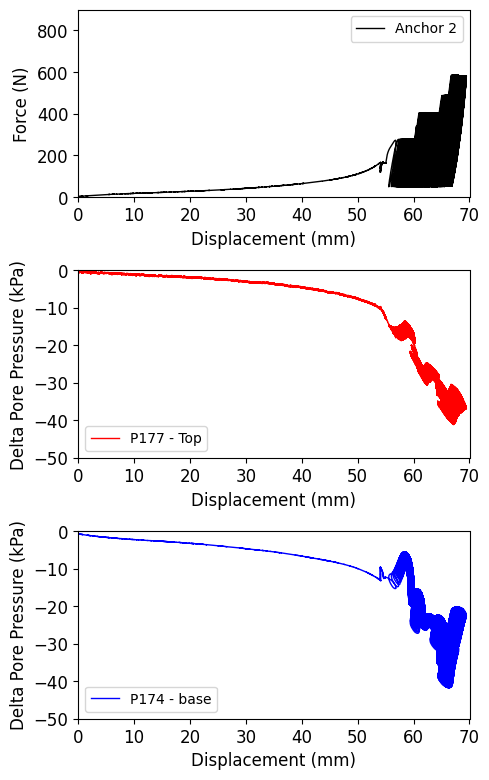

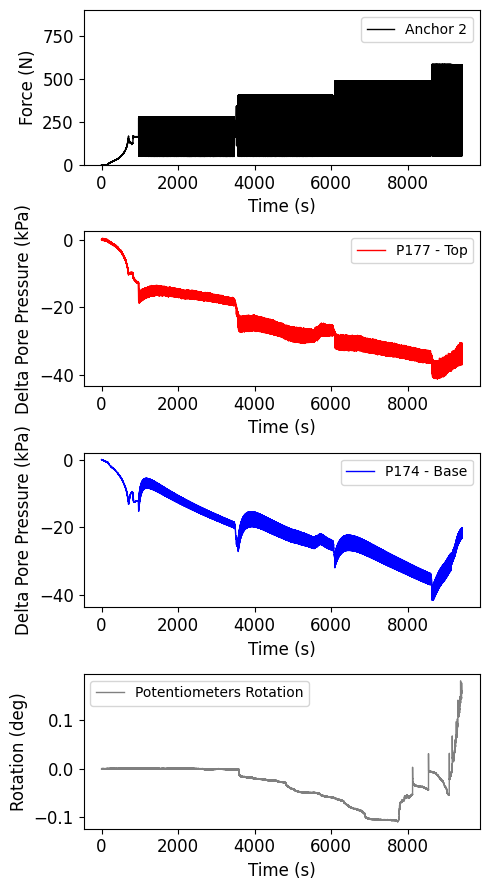

In [26]:
# Import necessary libraries
import pandas as pd # For data manipulation and reading CSV files
import numpy as np # For numerical operations, especially array manipulations
import matplotlib.pyplot as plt # For creating plots and visualizations
from scipy.signal import savgol_filter # For smoothing data

# --- Data Loading and Constants ---

# Load data from the CSV file for Anchor 2 Cyclic Inclined test (SW_02_2_I_CY)
# Assumes the CSV file is in the same directory or path is specified
datafile = wget.download( "https://zenodo.org/records/15174989/files/SW_02_2_I_CY.csv?download=1")
data = pd.read_csv('SW_02_2_I_CY.csv')
# Convert the pandas DataFrame into a NumPy array for easier indexing
Data = data.values

# Define constants based on the experimental setup (same as Anchor 1)
N = 75   # Centrifuge acceleration level (g-level)

# Anchor dimensions (model scale)
L = 200  # mm, anchor length
d = 60   # mm, anchor diameter
mass = 218.3 # grams, submerged anchor weight (assumed same for all anchors)
# Calculate prototype anchor weight in MN (same calculation as before)
# Note: The factor 0.01 might represent gravity/1000 conversion. Verify based on source paper's conventions.
wprot = mass * (N ** 3) * 0.01 / 1_000_000 # Using 1_000_000 for clarity (same as 1e6)

# --- Data Processing (Model Scale) ---
# Extract and process data columns for model scale analysis for Anchor 2 Cyclic Test

# Time array (Column 1, index 0)
time = Data[:, 0]

# Force measured by actuator (Column 2, index 1)
# Apply offset correction: Subtract the mean of the initial readings (first 20 points)
# Apply the same additional manual offset (-0.83 N) as used for Anchor 1 (verify if appropriate for Anchor 2)
mforce2 = Data[:, 1] - np.mean(Data[:20, 1]) - 0.83

# Displacement measured by actuator (Column 9, index 8 for SW_02_2_I_CY file)
# Apply offset correction: Subtract the mean of the initial readings
# Invert the sign (* -1) to match displacement convention
mdispl2 = (Data[:, 8] - np.mean(Data[:20, 8])) * -1

# --- Data Processing (Prototype Scale) ---
# Scale the model data to prototype equivalents using centrifuge scaling laws

# Time (Scaling law: T_prototype = T_model * N)
time2 = Data[:, 0] * N

# Force (Scaling law: F_prototype = F_model * N^2)
# Convert force units from N to MN (/1,000,000)
force2 = Data[:, 1] * (N ** 2) / 1_000_000
# Apply offset correction at prototype scale based on initial readings
force2 = force2 - np.mean(force2[:20])
# Apply Savitzky-Golay filter to smooth the prototype force data (15-point window, 1st-order poly)
force2 = savgol_filter(force2, 15, 1)

# Displacement (Scaling law: D_prototype = D_model * N)
# Use actuator displacement (Column 9, index 8)
# Convert displacement units from mm to m (/1000)
# Invert the sign to match convention
displ2 = -Data[:, 8] * N / 1000
# Apply offset correction at prototype scale based on initial readings
displ2 = displ2 - np.mean(displ2[:20])

# Normalized Displacement (Displacement / Prototype Diameter)
# Calculate prototype diameter (d * N / 1000)
ndispl2 = displ2 / ((d * N) / 1000)

# --- Pore Pressure Processing ---
# Extract pore pressure data and apply offset correction for Anchor 2
# Note: Data paper mentions P175 malfunctioned for Anchor 2 test, so only P177 and P174 are used.

# Pore pressure at anchor top (Sensor P177, Column 6, index 5 for SW_02_2_I_CY)
p177 = Data[:, 5] - np.mean(Data[:20, 5])
# Pore pressure at anchor base (Sensor P174, Column 8, index 7 for SW_02_2_I_CY)
p174 = Data[:, 7] - np.mean(Data[:20, 7])


# --- Rotation Calculations ---
# Calculate anchor rotation based on pairs of displacement sensors for Anchor 2

# Rotation from Laser Transducers (D161, D159)
# Laser D161 displacement (Column 7, index 6 for SW_02_2_I_CY), offset corrected and smoothed
d161 = savgol_filter(Data[:, 6] - np.mean(Data[:20, 6]), 15, 1)
# Laser D159 displacement (Column 3, index 2 for SW_02_2_I_CY), offset corrected and smoothed
d159 = savgol_filter(Data[:, 2] - np.mean(Data[:20, 2]), 15, 1)
# Calculate rotation angle (difference in displacement / 80 mm separation distance)
# Convert radians to degrees
rot_laser = np.degrees(np.arctan((d161 - d159) / 80))

# Rotation from Potentiometers (D151, D37)
# Potentiometer D151 displacement (Column 5, index 4 for SW_02_2_I_CY), offset corrected and sign inverted
d151 = (Data[:, 4] - np.mean(Data[:20, 4])) * -1
# Potentiometer D37 displacement (Column 4, index 3 for SW_02_2_I_CY), offset corrected
d37 = Data[:, 3] - np.mean(Data[:20, 3])
# Calculate rotation angle (difference in displacement / 47 mm separation distance)
# Convert radians to degrees and invert sign based on setup convention
rot_pot = -np.degrees(np.arctan((d151 - d37) / 47))

# Define counter to limit plot points (covers the duration of the cyclic test)
counter = 941405 # Corresponds to the approximate number of samples in the test data

# --- FIGURE 1: Lateral load and pore pressure vs Displacement (Model Scale) ---
# Creates plots similar to Figure 9 in the data paper
plt.figure(figsize=(5, 10)) # Set figure size (width, height in inches)

# Subplot 1: Force vs Displacement
plt.subplot(4, 1, 1) # Changed to 4 rows, 1 col, 1st plot to match structure (though only 3 plots needed)
plt.plot(mdispl2[:counter], -mforce2[:counter], 'k', linewidth=1) # Plot model displacement vs negative model force
plt.xlabel('Displacement (mm)', fontsize=12)
plt.ylabel('Force (N)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim([0, 70]) # Adjust x-limit based on observed cyclic displacement range
plt.ylim([0, 900]) # Adjust y-limit based on observed cyclic force range
plt.legend(['Anchor 2'], fontsize=10) # Legend indicating Anchor 2 data

# Subplot 2: Pore Pressure (Top - P177) vs Displacement
plt.subplot(4, 1, 2) # 4 rows, 1 col, 2nd plot
plt.plot(mdispl2[:counter], p177[:counter], 'r', linewidth=1) # Plot displacement vs P177
plt.xlabel('Displacement (mm)', fontsize=12)
plt.ylabel('Delta Pore Pressure (kPa)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim([0, 70])
plt.ylim([-50, 0]) # Adjust y-limit for observed pore pressure range
plt.legend(['P177 - Top'], fontsize=10)

# Subplot 3: Pore Pressure (Base - P174) vs Displacement
plt.subplot(4, 1, 3) # 4 rows, 1 col, 3rd plot
plt.plot(mdispl2[:counter], p174[:counter], 'b', linewidth=1) # Plot displacement vs P174
plt.xlabel('Displacement (mm)', fontsize=12)
plt.ylabel('Delta Pore Pressure (kPa)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim([0, 70])
plt.ylim([-50, 0]) # Adjust y-limit for observed pore pressure range
plt.legend(['P174 - base'], fontsize=10)

# Note: 4th subplot is left empty as P175 data was not available/reliable for Anchor 2


# Adjust layout and save the figure
plt.tight_layout() # Adjust subplot params for a tight layout
plt.savefig('Lateral_load_vs_displacement_anchor2.pdf') # Save figure as PDF
plt.savefig('Lateral_load_vs_displacement_anchor2.svg') # Save figure as SVG
plt.show() # Display the plot

# --- FIGURE 2: Time series plots (Model Scale) ---
# Creates plots similar to Figure 10 in the data paper
plt.figure(figsize=(5, 9)) # Set figure size

# Subplot 1: Force vs Time
plt.subplot(4, 1, 1) # 4 rows, 1 column, 1st subplot
plt.plot(time[:counter], -mforce2[:counter], 'k', linewidth=1) # Plot time vs negative model force
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Force (N)', fontsize=12)
plt.ylim([0, 900]) # Set y-limit based on observed force range
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['Anchor 2'], fontsize=10)

# Subplot 2: Pore Pressure (Top - P177) vs Time
plt.subplot(4, 1, 2) # 4 rows, 1 column, 2nd subplot
plt.plot(time[:counter], p177[:counter], 'r', linewidth=1) # Plot time vs P177
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Delta Pore Pressure (kPa)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['P177 - Top'], fontsize=10)

# Subplot 3: Pore Pressure (Base - P174) vs Time
plt.subplot(4, 1, 3) # 4 rows, 1 column, 3rd subplot
plt.plot(time[:counter], p174[:counter], 'b', linewidth=1) # Plot time vs P174
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Delta Pore Pressure (kPa)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['P174 - Base'], fontsize=10)

# Subplot 4: Rotation (from Potentiometers) vs Time
plt.subplot(4, 1, 4) # 4 rows, 1 column, 4th subplot
plt.plot(time[:counter], rot_pot[:counter], color='gray', linewidth=1) # Plot time vs rotation from potentiometers
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Rotation (deg)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['Potentiometers Rotation'], fontsize=10) # Legend indicating potentiometer rotation

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Time_series_anchor2.pdf') # Save figure as PDF
plt.savefig('Time_series_anchor2.svg') # Save figure as SVG
plt.show() # Display the plot

# Anchor 3

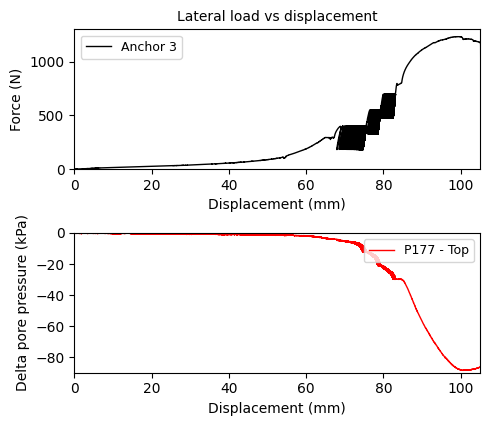

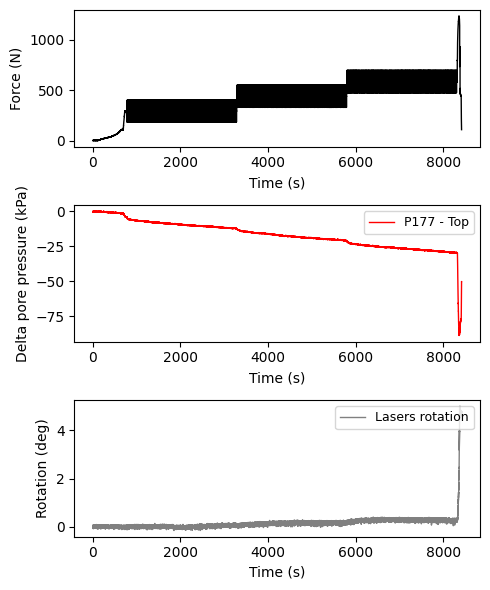

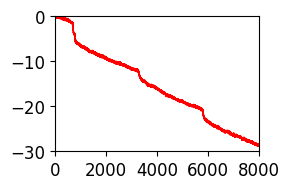

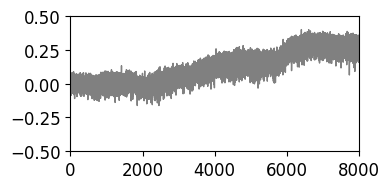

In [27]:
# Import necessary libraries
import pandas as pd # For data manipulation and reading CSV files
import numpy as np # For numerical operations, especially array manipulations
import matplotlib.pyplot as plt # For creating plots and visualizations
from scipy.signal import savgol_filter # For smoothing data

# --- Data Loading and Constants ---

# Load data from the CSV file for Anchor 3 Cyclic Inclined test (SW_02_3_I_CY)
# Assumes the CSV file is in the same directory or path is specified
datafile = wget.download( "https://zenodo.org/records/15174989/files/SW_02_3_I_CY.csv?download=1")
data = pd.read_csv('SW_02_3_I_CY.csv')
# Convert the pandas DataFrame into a NumPy array for easier indexing
Data = data.values

# Define constants based on the experimental setup (same as Anchors 1 & 2)
N = 75   # Centrifuge acceleration level (g-level)
L = 200  # mm, anchor length (model scale)
d = 60   # mm, anchor diameter (model scale)
mass = 218.3 # grams, submerged anchor weight (model scale)
# Calculate prototype anchor weight in MN (same calculation as before)
# Note: The factor 0.01 might represent gravity/1000 conversion. Verify based on source paper's conventions.
wprot = mass * (N**3) * 0.01 / 1_000_000 # Using 1_000_000 for clarity (same as 1e6)

# --- Data Processing (Model Scale) ---
# Extract and process data columns for model scale analysis for Anchor 3 Cyclic Test

# Time array (Column 1, index 0)
time = Data[:, 0]

# Force measured by actuator (Column 2, index 1)
mforce2 = Data[:, 1]
# Apply offset correction: Subtract the mean of the initial readings (first 20 points)
# Apply the same additional manual offset (-0.83 N) as used for Anchors 1 & 2 (verify if appropriate for Anchor 3)
# Note: The comment 'DaN' seems incorrect based on previous scripts and typical units; assuming N.
mforce2 = mforce2 - np.mean(mforce2[:20]) - 0.83 # Assuming unit is N, not DaN

# Displacement measured by actuator (Column 8, index 7 for SW_02_3_I_CY file)
mdispl2 = Data[:, 7]
# Apply offset correction: Subtract the mean of the initial readings
# Invert the sign (* -1) to match displacement convention (e.g., positive pullout displacement)
mdispl2 = (mdispl2 - np.mean(mdispl2[:20])) * -1 # Resulting displacement in mm

# --- Data Processing (Prototype Scale) ---
# Scale the model data to prototype equivalents using centrifuge scaling laws

# Time (Scaling law: T_prototype = T_model * N)
time2 = time * N

# Force (Scaling law: F_prototype = F_model * N^2)
# Convert force units from N to MN (/1,000,000)
force2 = Data[:, 1] * (N**2) / 1_000_000
# Apply offset correction at prototype scale based on initial readings
force2 = force2 - np.mean(force2[:20]) # Offset based on initial prototype force values
# Apply Savitzky-Golay filter to smooth the prototype force data (15-point window, 1st-order poly)
force2 = savgol_filter(force2, 15, 1) # smoothed force in MN

# Displacement (Scaling law: D_prototype = D_model * N)
# Use actuator displacement (Column 8, index 7)
# Convert displacement units from mm to m (/1000)
# Invert the sign to match convention
displ2 = -Data[:, 7] * N / 1000 # displacement in m
# Apply offset correction at prototype scale based on initial readings
displ2 = displ2 - np.mean(displ2[:20])

# Normalized Displacement (Displacement / Prototype Diameter)
# Calculate prototype diameter (d * N / 1000)
ndispl2 = displ2 / ((d * N) / 1000) # normalized displacement (dimensionless)

# --- Pore Pressure Processing ---
# Extract pore pressure data and apply offset correction for Anchor 3
# Note: Data paper indicates P170 (Base) and P129 (1D below) malfunctioned during the Anchor 3 test.
#       Only P177 (Top) provided reliable data, though the others are extracted here.

# Pore pressure at anchor top (Sensor P177, Column 4, index 3 for SW_02_3_I_CY) - Reliable
p177 = Data[:, 3] - np.mean(Data[:20, 3])
# Pore pressure at anchor base (Sensor P170, Column 6, index 5 for SW_02_3_I_CY) - Malfunctioned
p170 = Data[:, 5] - np.mean(Data[:20, 5])
# Pore pressure 1D below base (Sensor P129, Column 7, index 6 for SW_02_3_I_CY) - Malfunctioned
p129 = Data[:, 6] - np.mean(Data[:20, 6])

# --- Rotation Calculations ---
# Calculate anchor rotation based on laser displacement sensors for Anchor 3

# Rotation from Laser Transducers (D161, D159)
# Laser D161 displacement (Column 5, index 4 for SW_02_3_I_CY), offset corrected and smoothed
# Using a slightly different window length (17) for Savitzky-Golay filter here
d161 = Data[:, 4] - np.mean(Data[:20, 4])
d161 = savgol_filter(d161, 17, 1)

# Laser D159 displacement (Column 3, index 2 for SW_02_3_I_CY), offset corrected and smoothed
d159 = Data[:, 2] - np.mean(Data[:20, 2])
d159 = savgol_filter(d159, 17, 1)

# Calculate rotation angle (difference in displacement / 80 mm separation distance)
# Convert radians to degrees
rot_laser = np.degrees(np.arctan((d161 - d159) / 80))

# --- Plotting ---

# Define counter to limit plot points (covers duration of test including post-cyclic monotonic pullout)
counter = 842000
# Define horizontal scale limit for displacement plots
hor_scale_2 = 105 # mm

# --- FIGURE 1: Model scale results - Force & Reliable Pore Pressure vs Displacement ---
# Creates plots similar to Figure 11 in the data paper (top and bottom panels)
plt.figure(1, figsize=(5, 8)) # Define figure number 1 and size

# Subplot 1: Force vs Displacement (Model Scale)
plt.subplot(4, 1, 1) # Using 4 rows to maintain consistent vertical spacing, even if only 2 are used
plt.plot(mdispl2[:counter], -mforce2[:counter], 'k', linewidth=1) # Plot displacement vs negative force
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.xlim([0, hor_scale_2]) # Use defined horizontal scale limit
plt.ylim([0, 1300]) # Adjust y-limit for observed force range including post-cyclic pullout
plt.legend(['Anchor 3'], loc='upper left', fontsize=9) # Legend for Anchor 3
plt.title('Lateral load vs displacement', fontsize=10) # Add title
plt.grid(False) # Turn off grid

# Subplot 2: Pore Pressure (Top - P177) vs Displacement (Model Scale)
plt.subplot(4, 1, 2) # Second subplot in the 4-row layout
plt.plot(mdispl2[:counter], p177[:counter], 'r', linewidth=1) # Plot displacement vs P177
plt.xlabel('Displacement (mm)')
plt.ylabel('Delta pore pressure (kPa)')
plt.xlim([0, hor_scale_2])
plt.ylim([-90, 0]) # Adjust y-limit for observed pore pressure range
plt.legend(['P177 - Top'], loc='upper right', fontsize=9) # Legend for P177
plt.grid(False)

# Note: Subplots 3 and 4 are left empty as other PPTs malfunctioned.

plt.tight_layout() # Adjust layout
plt.savefig('Lateral_load_vs_displacement_anchor3.svg', format='svg') # Save figure as SVG

# --- FIGURE 2: Time series plots (Model Scale) ---
# Creates plots similar to Figure 12 in the data paper
plt.figure(2, figsize=(5, 6)) # Define figure number 2 and size

# Subplot 1: Force vs Time
plt.subplot(3, 1, 1) # 3 rows, 1 column, 1st subplot
plt.plot(time[:counter], -mforce2[:counter], 'k', linewidth=1) # Plot time vs negative model force
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.grid(False)

# Subplot 2: Pore Pressure (Top - P177) vs Time
plt.subplot(3, 1, 2) # 3 rows, 1 column, 2nd subplot
plt.plot(time[:counter], p177[:counter], 'r', linewidth=1) # Plot time vs P177
plt.legend(['P177 - Top'], loc='upper right', fontsize=9)
plt.xlabel('Time (s)')
plt.ylabel('Delta pore pressure (kPa)')
plt.grid(False)

# Subplot 3: Rotation (from Lasers) vs Time
plt.subplot(3, 1, 3) # 3 rows, 1 column, 3rd subplot
plt.plot(time[:counter], -rot_laser[:counter], color='gray', linewidth=1) # Plot time vs negative laser rotation
plt.legend(['Lasers rotation'], loc='upper right', fontsize=9)
plt.xlabel('Time (s)')
plt.ylabel('Rotation (deg)')
plt.grid(False)

plt.tight_layout() # Adjust layout
plt.savefig('Time_series_anchor3.svg', format='svg') # Save figure as SVG

# --- FIGURE 3: Small plot for PPT only (Zoomed Time Series) ---
# Creates a focused view of the reliable pore pressure data over time
plt.figure(3, figsize=(3, 2)) # Define figure number 3 and smaller size
plt.plot(time[:counter], p177[:counter], 'r', linewidth=1) # Plot time vs P177
plt.tick_params(axis='both', which='major', labelsize=12) # Adjust tick label size
plt.ylim([-30, 0]) # Set Y-axis limits for zoom effect
plt.xlim([0, 8000]) # Set X-axis limits to focus on the main test duration
plt.grid(False)
plt.tight_layout()
plt.savefig('PPT_time_series_anchor3.svg', format='svg') # Save figure as SVG


# --- FIGURE 4: Small plot for laser rotation only (Zoomed Time Series) ---
# Creates a focused view of the laser rotation data over time
plt.figure(figsize=(4, 2)) # Define figure size (note: figure number not specified, will default)
plt.plot(time[:counter], -rot_laser[:counter], color='gray', linewidth=1) # Plot time vs negative laser rotation
plt.tick_params(axis='both', which='major', labelsize=12) # Adjust tick label size
plt.ylim([-0.5, 0.5]) # Set Y-axis limits for zoom effect on rotation
plt.xlim([0, 8000]) # Set X-axis limits to focus on the main test duration
plt.grid(False)
plt.tight_layout()
plt.savefig('laser_rotation_time_series_anchor3.svg', format='svg') # Save figure as SVG

# Show all generated figures
plt.show()

# T-Bar tests

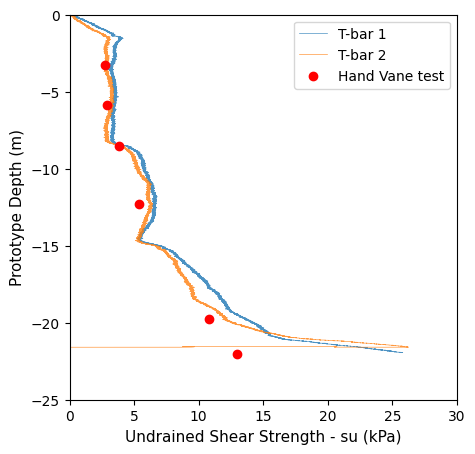

In [28]:
# Import necessary libraries
import pandas as pd # For data manipulation and reading CSV files
import numpy as np # For numerical operations
import matplotlib.pyplot as plt # For creating plots and visualizations
from scipy.signal import savgol_filter # Although imported, not used in this specific script


## Download the Tbar test files from Zenodo repository
datafile1 = wget.download( "https://zenodo.org/records/15174989/files/SW_02_TBAR1_MO.csv?download=1")
datafile2 = wget.download( "https://zenodo.org/records/15174989/files/SW_02_TBAR2_MO.csv?download=1")



# --- Constants and T-bar Geometry ---

# Define T-bar dimensions (as originally provided in the script)
# NOTE: Data paper text mentions L=20mm, D=5mm. Verify these values are correct for the intended calculation.
LE = 200  # mm - Original value used in the script
DI = 60   # mm - Original value used in the script
# Calculate the projected area (A) of the T-bar in square meters based on the LE and DI above
A = (LE / 1000) * (DI / 1000)  # m^2 - Original calculation

# --- Function Definition ---

# Function to process a single T-bar CSV file
def process_tbar_csv(file, depth_offset_points=20, force_offset_points=20, depth_manual_offset=0.0):
    """
    Reads a T-bar CSV file, calculates undrained shear strength (su),
    adjusts depth to prototype scale, and applies offset corrections.

    Args:
        file (str): Path to the CSV file.
        depth_offset_points (int): Number of initial points to use for depth offset calculation.
        force_offset_points (int): Number of initial points to use for force offset calculation.
        depth_manual_offset (float): A manual offset to apply to the prototype depth (e.g., alignment adjustment).

    Returns:
        tuple: (prototype_depth, su) - NumPy arrays for prototype depth (m) and undrained shear strength (kPa).
    """
    # Read the CSV file using pandas
    df = pd.read_csv(file)
    # Extract force data (Column 2, index 1)
    # NOTE: Data paper (p16) suggests units might be DaN. Check if conversion (*10) is needed if input is DaN.
    force = df.iloc[:, 1]
    # Extract depth data (Column 3, index 2 - assuming 'z.Tbar' in mm as per page 16)
    depth = df.iloc[:, 2]

    # --- Force Processing ---
    # Apply offset correction to force using the mean of initial points
    force_offset = force[:force_offset_points].mean()
    force_corrected = force - force_offset
    # NOTE: If force input is DaN, conversion is needed: force_corrected_N = force_corrected * 10

    # --- Strength Calculation ---
    # Calculate cone resistance qc = Force / Area
    # NOTE: Ensure 'force_corrected' units match area units (e.g., N and m^2 -> Pa)
    # Conversion factor 100 might be converting force units? Needs clarification. Result divided by 1000 for kPa.
    # Original calculation:
    qc = ((force_corrected * 100) / A) / 1000  # kPa - Original calculation
    # Calculate undrained shear strength (su) using qc and the T-bar factor Nt=10.5 (from data paper p13)
    # Note the negative sign in the original calculation. Check force sign convention.
    su = -qc / 10.5 # su in kPa - Original calculation

    # --- Depth Processing ---
    # Scale model depth (mm) to prototype depth (m) using N=75
    # prototype_depth = model_depth * N / 1000
    depth_scaled = depth * 75 / 1000 # Prototype depth in m relative to start of penetration
    # Apply automatic offset correction based on initial penetration points
    depth_offset = depth_scaled[:depth_offset_points].mean()
    # Apply manual offset provided for the specific test file
    # Resulting depth is relative to a corrected zero point at prototype scale
    prototype_depth = depth_scaled - depth_offset + depth_manual_offset

    return prototype_depth, su

# --- Data Specification ---

# List of T-bar CSV files to process and their respective manual depth offsets
# The manual offsets might be used to align the start of the T-bar tests relative to a common datum
tbar_files = [
    ('SW_02_TBAR1_MO.csv', 2.71), # File name and its manual depth adjustment
    ('SW_02_TBAR2_MO.csv', 0.5)  # File name and its manual depth adjustment
]

# Manual data points,  from Hand Vane tests for comparison (as shown in Figure 13 OF DATA REPORT)
manual_su = [2.74, 3.82, 5.39, 10.8, 13, 2.9] # su values (kPa)
manual_depth = [-3.26, -8.51, -12.26, -19.76, -22.01, -5.88] # Corresponding prototype depths (m)

# --- Plotting ---

# Create the plot figure
plt.figure(figsize=(5, 5)) # Set figure size

# Loop through each T-bar file defined above
for i, (file, depth_offset) in enumerate(tbar_files, start=1):
    # Process the current T-bar file using the defined function (with original logic)
    depth, su = process_tbar_csv(file, depth_manual_offset=depth_offset)
    # Plot the results (su vs prototype depth)
    # Limit plotted points to first 24000 for clarity/performance
    # Use transparency (alpha) for potentially overlapping lines
    plt.plot(su[:24000], depth[:24000], linewidth=0.5, label=f'T-bar {i}', alpha=0.8)

# Plot the manual Hand Vane test data points as red circles
# zorder=5 ensures these points are plotted on top of the T-bar lines
plt.scatter(manual_su, manual_depth, color='red', marker='o', label='Hand Vane test', zorder=5)

# --- Plot Formatting ---
# Apply labels, legend, grid, ticks, and axis limits

plt.xlabel('Undrained Shear Strength - su (kPa)', fontsize=11) # X-axis label
plt.ylabel('Prototype Depth (m)', fontsize=11) # Y-axis label
plt.grid(False) # Turn off the grid
plt.legend(fontsize=10) # Display the legend
plt.xticks(fontsize=10) # Set x-axis tick label size
plt.yticks(fontsize=10) # Set y-axis tick label size
plt.xlim(0, 30) # Set x-axis limits (su range)
plt.ylim(top=0, bottom=-25) # Set y-axis limits (depth range, 0 at top)

# --- Save and Show Plot ---

plt.savefig('tbar_su_profiles.pdf') # Save the plot as a PDF file
# plt.savefig('tbar_su_profiles.svg') # Option to save as SVG (commented out)
plt.show() # Display the plot window